## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [20]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [38]:
# read in the dataset
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [62]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [63]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [66]:
proportion_converted=(df['converted']==1).mean()*100
print("The proportion of users converted is {} %.".format(proportion_converted))

The proportion of users converted is 11.96591935560551 %


e. The number of times the `new_page` and `treatment` don't line up.

In [67]:
# mismatch where group is treatment and landing page is not new page
not_equal1=(df[(df['group']=='treatment') & (df['landing_page']!='new_page')]).shape[0]

In [68]:
# mismatch where landing page is new page and group is not treatment
not_equal2=(df[(df['landing_page']=='new_page') & (df['group']!='treatment')]).shape[0]

In [69]:
total_unequal= not_equal1+not_equal2
print("No. of times new_page and treatment don't line up is {}.".format(total_unequal))

No. of times new_page and treatment don't line up is 3893.


f. Do any of the rows have missing values?

In [70]:
# do all columns have same number of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [22]:
# find the rows with any missing values and add them
(df.isnull().sum(axis=1)).sum()

0

**There is no row with missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [39]:
# drop rows where treatment and new_page don't line up
df2=df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [40]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [24]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
# the ids that are duplicate, includes the first one as well
df2[df2.user_id.duplicated(keep=False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

**user_id 773192 has duplicate information.**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [41]:
# find the index of the duplicated id and drop it
df2=df2.drop(df2[df2.user_id.duplicated() == True].index)

In [42]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [43]:
# probability of an individual having 1 in converted column
converted_prob=(df2['converted']==1).mean()
print("Probability of an individual converting regardless of the page they receive is {}.".format(converted_prob))

Probability of an individual converting regardless of the page they receive is 0.11959708724499628.


b. Given that an individual was in the `control` group, what is the probability they converted?

In [44]:
# probability of conversion being in the control group
control_prob=df2.query('group=="control"').converted.mean()
print("Probability of an individual converting from control group is {}.".format(control_prob))

Probability of an individual converting from control group is 0.1203863045004612.


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [45]:
# probability of conversion being in the treatment group
treatment_prob=df2.query('group=="treatment"').converted.mean()
print("Probability of an individual converting from treatment group is {}.".format(treatment_prob))

Probability of an individual converting from treatment group is 0.11880806551510564.


In [46]:
# difference in the probability of an individual converting, belonging to the two groups.
diff=treatment_prob-control_prob
diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [47]:
# the probability that an individual received the new page
received_new=df2[df2['landing_page']=="new_page"].landing_page.count()/df2.shape[0]
print("The probability that an individual received the new page is {}.".format(received_new))

The probability that an individual received the new page is 0.5000619442226688.


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**I don't think there is enough evidence to suggest that the new treatment leads to more conversions. We know that there is a 50-50 chance that an individual will receive the new page. The control group has slightly more conversion than the treatment group. We need to test if the difference is significant or not.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new}<=p_{old}$$
$$H_1: p_{new}>p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [52]:
pnew=converted_prob
pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [48]:
pold=converted_prob
pold

0.11959708724499628

c. What is $n_{new}$?

In [49]:
# no of samples shown new_page
nnew=df2[df2['landing_page']=="new_page"]['user_id'].count()

d. What is $n_{old}$?

In [50]:
# no of samples shown old_page
nold=df2[df2['landing_page']=="old_page"]['user_id'].count()

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [53]:
new_page_converted=np.random.binomial(1, pnew, nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [54]:
old_page_converted=np.random.binomial(1, pold, nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [55]:
diff_page=new_page_converted.mean()-old_page_converted.mean()
diff_page

-0.0006008183433614256

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [57]:
# sampling distribution of the difference of the means of conversions for old page and new page
new_converted_simulation = np.random.binomial(nnew, pnew, 10000)/nnew
old_converted_simulation = np.random.binomial(nold, pold, 10000)/nold
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

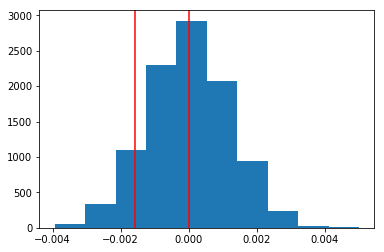

In [58]:
# Convert to numpy array
p_diffs = np.array(p_diffs)
# Plot sampling distribution with null mean of 0 as the center
plt.hist(p_diffs)
plt.axvline(0, color='red')
plt.axvline(diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [59]:
# proportion of p_diffs greater than the actual difference observed in part 1
(p_diffs>diff).mean()

0.9011

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j we computed the p-value based on the null hypothesis (question 2) that pnew-pold=0.This was calculated from the sampling distribution of the difference of means which in this case is same as the sampling distribution under the null hypothesis as it is centered at 0 (which is the null mean, since the null hypothesis is pnew-pold=0 and the alternative hypothesis is pnew-pold>0) and has the same spread.**

**The p-value is 0.903 which is greater than alpha=0.05 thus we fail to reject the null hypothesis. So we see that we fail to reject the null hupothesis. So, there is no difference between the new and old page and hence no reason to move away from the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [107]:
# the number of conversions for each pag
convert_old = df2[df2['landing_page']=='old_page'].converted.sum()
convert_new = df2[df2['landing_page']=='new_page'].converted.sum()
#the number of individuals who received each page
n_old = nold
n_new = nnew

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [108]:
# compute z-score and p-value for one tailed test using stats.proportions_ztest 
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [115]:
# how significant our z-score is
print("Significance of z-score is {}.".format(norm.cdf(z_score)))

# our critical value at 95% confidence is
print("The critical value is {}".format(norm.ppf(1-(0.05/2))))

Significance of z-score is 0.09494168724097551.
The critical value is 1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of -1.31 is less than the critical value of 1.959963984540054, we fail to reject the null hypothesis that there is no difference between the two proportions and they are equal to the converted rate in ab_data.csv regardless of the page.**

**This is perfectly in line with our previous findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we have a nominal(true or false for conversion) variable as the dependent variable, we should use Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [120]:
# create dummy variables for the group variable
df2[['page','ab_page']]=pd.get_dummies(df2['group'])

In [121]:
# dropping the page dummy variables as ab_page gives the same information
df2=df2.drop('page', axis=1)

In [119]:
# add intercept to the data 
df2['intercept']=1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [123]:
# instantiate the logistic regression model
logit_model_df2=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
#fit the model
results_df2=logit_model_df2.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [124]:
# get the summary
results_df2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        15:03:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [126]:
# The estimated coefficients are the log odds. By exponentiating these values,we can calculate 
# the odds. And since the coefficient is negative, we invert the odds ratio to find the relation 
# between conversion rate and the ab_page
1/np.exp(-0.0150)

1.015113064615719

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The P value associated with the ab_page is 0.190, which is higher than the alpha value of 0.05. So we fail to reject the null hypothesis.**

**For the logistic regression the null hypothesis is there is no relationship between the landing page and conversion rate. So there should be no difference in conversion rate based on the page or $$pnew-pold=0$$ and the alternate hypothesis is there is relation between the two so $$pnew-pold\neq0$$ . Here it is a two tail test and hence we see a difference in the p value obtained from part 2 where we had the alternate hypothesis pnew-pold >0.**

**Also from the coefficient of ab_page we can say that the conversion rate for the old page is 1.015 times of the new page. So they are almost same which aligns with our proposition of failing to reject the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more than one explanatory variable to the regression model help us determine the relative influence that more than one predictor have on the response. This multiple logistic regression might help to get insights that is not possible just from single logistic regression. Such as we can see if certain landing pages lead to more conversion for certain countries or certain times of the day or week that would not be possible with just the landing page variable. It also helps identify outliers in the sample data.**

**Adding additional terms to the model has the disadvantage that instead of increasing the quality of the model it could decrease it.Incomplete data can leads to concluding of an incorrect relationship between the variables.Also it could lead to falsely concluding that correlation is a causation.**

**https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [127]:
# read from the dataset and merge the two datasets based on the user_id column
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [128]:
df_new.head(5)

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [129]:
# Create the necessary dummy variables
df_new[['ca', 'uk', 'us']]=pd.get_dummies(df_new['country'])

In [132]:
# logistic regression with the ab_page and countries (ca as the baseline)
logit_model_df_page_country=sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk']])
results_df_page_country=logit_model_df_page_country.fit()
results_df_page_country.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        15:34:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
us             0.0408      0.027      1.516      0.130      -0.012       0.093
uk             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [133]:
# odds ratio
np.exp(results_df_page_country.params)

intercept    0.131332
ab_page      0.985168
us           1.041599
uk           1.051944
dtype: float64

**We find conversion rate is not effected by countries or different landing page. 
From the coefficient of US we can say that the conversion rate for US is 1.04 times of CA holding all other variables constant.
From the coefficient of UK we can say that the conversion rate of UK is 1.05 times of CA holding all other variables constant. 
None of the predictors are statistically significant**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [135]:
# Fit Your Linear Model And Obtain the Results
# Find the interaction terms
df_new['page_us'] = df_new.ab_page * df_new.us
df_new['page_uk'] = df_new.ab_page * df_new.uk

# Relation between converted and the pages, countries and pages*countries
model_multiply = smf.ols(formula='converted ~ ab_page + us + page_us+ uk+ page_uk', data=df_new).fit()
summary_multiply = model_multiply.summary()
summary_multiply

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Fri, 11 Jan 2019   Prob (F-statistic):              0.197
Time:                        15:43:11   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
us             0.0018      0.004      0.467      0.641      -0.006       0.010
page_us        0.0047      0.006      0.845      0.398      -0.006       0.016
uk             0.0012      0.004      0.296      0.767      -0.007       0.009
page_uk        0.0080      0.006      1.360      0.174      -0.004       0.020
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From the p values we can see that none of the tested variables are less than 0.05. So we fail to reject the null hypothesis that there is no relation between the tested X variables, country and page and y variable, conversion. The interactions also had P values more than 0.05 so no particular landing page had any effect on the country. Also we have a R-squared value of 0, suggesting no relationship at all**

In [79]:
logit_model_multiply = smf.logit(formula='converted ~ ab_page + us + page_us+ uk+ page_uk', data=df_new).fit()
summary_logit = logit_model_multiply.summary()
summary_logit

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:05:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
us             0.0175      0.038      0.465      0.642      -0.056       0.091
page_us        0.0469      0.054      0.872      0.383      -0.059       0.152
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
page_uk        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**For logistic regression we also see that the p values are greater than 0.05. So the tested X variables (landing_page and country) or their interation terms didn't have any effect on the model. So we fail to reject the null hypothesis that there is no relationship between the response and predictor variables.**

### Additional Analysis:

**Effect of day of the week and time of the day on regression.**

We will create the necessary dummy varaiables.

In [137]:
# convert timestamp column to series and convert the series to day of week(Moday=0,...)
df_new['weekday'] = pd.to_datetime(df_new['timestamp']).dt.dayofweek

In [138]:
# convert weekday to 1 and weekend to 0
df_new['weekday']=(df_new['weekday'] < 5).astype(int) 

In [140]:
# convert the hours and minutes to decimals for categorising the day based on time in decimals
df_new['time'] = pd.to_datetime(df_new['timestamp']).dt.hour+pd.to_datetime(df_new['timestamp']).dt.minute/60

In [141]:
# Categorise the day based on the decimal time
df_new['time_aspect']=df_new.apply(lambda x: 'morning' if x.time>=7 and x.time<=12 else('afternoon' if x.time>12 and x.time<=18 else 'evening'), axis=1)

In [143]:
# Create the necessary dummy variables for time_aspect
df_new[['afternoon','evening', 'morning']]=pd.get_dummies(df_new['time_aspect'])

Since there are so many X variables now, we will check for multicollinearity

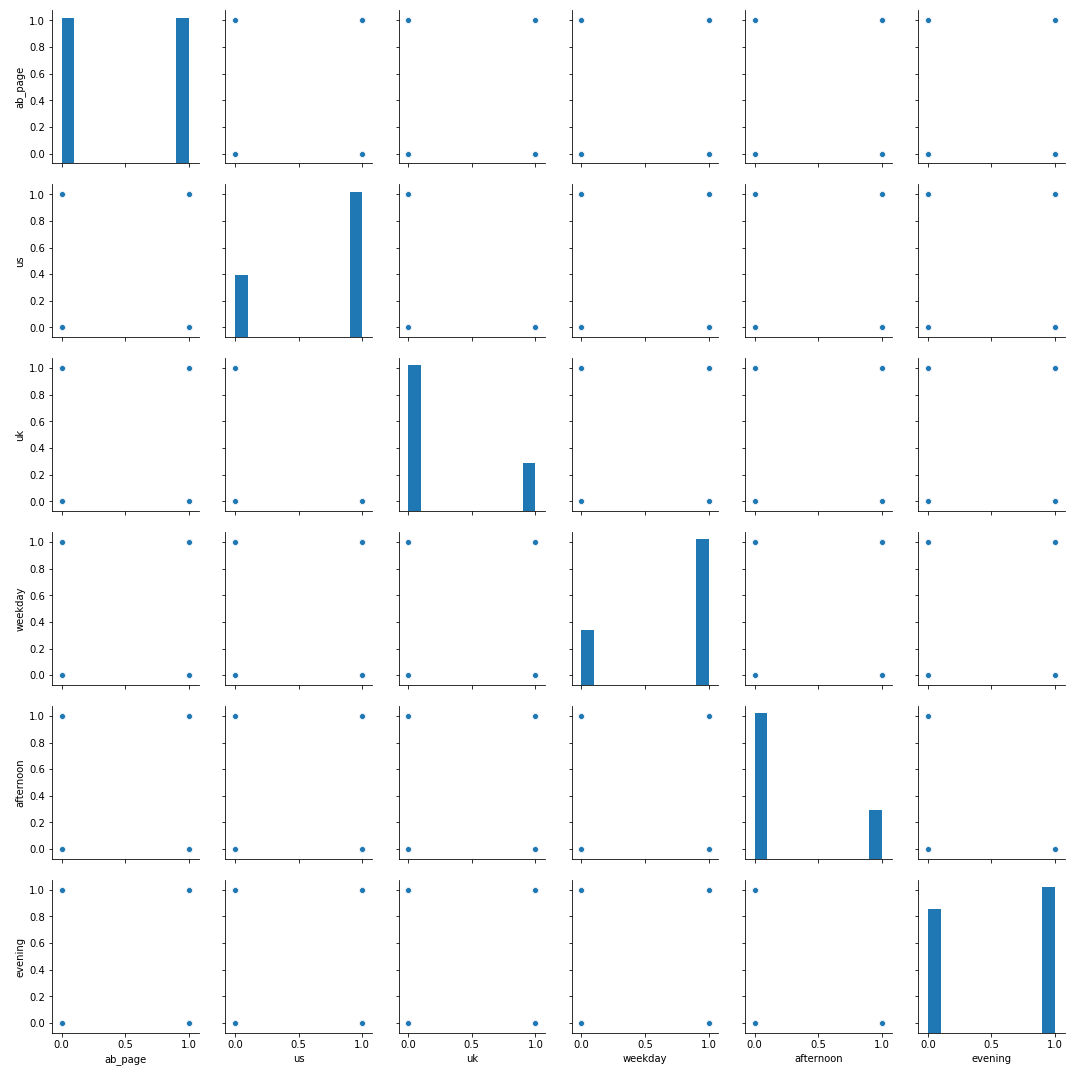

In [147]:
sns.pairplot(df_new[['ab_page', 'us', 'uk', 'weekday', 'afternoon', 'evening']]);

We don't see any linear correlation between the X variables. We can also check the variance inflation factor.

In [149]:
# Define y and X matrix
y,X=dmatrices('converted ~ ab_page+us+uk+weekday+afternoon+evening', data=df_new, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [150]:
vif

,VIF Factor,features
0,27.450996,Intercept
1,1.000026,ab_page
2,4.502318,us
3,4.502308,uk
4,1.000015,weekday
5,1.648171,afternoon
6,1.648119,evening


**Since the vif factors are less than 10 the predictor variables are not correlated with one another (No multicollinearity).**

We will create the interaction terms between page and weekday, page and afternoon, evening only as we are aiming to find out which page leads to better conversion and if other factors along with the page version can influence the conversion.

In [152]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,ca,uk,us,page_us,page_uk,weekday,time,time_aspect,afternoon,evening,morning
user_id,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0,23.133333,evening,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0,1,14.733333,afternoon,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,1,14.066667,afternoon,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0,0,3.233333,evening,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,1,13.233333,afternoon,1,0,0


In [153]:
# Create the interaction terms
df_new['page_weekday'] = df_new.ab_page * df_new.weekday
df_new['page_afternoon'] = df_new.us * df_new.afternoon
df_new['page_evening'] = df_new.us * df_new.evening

# Create the model and fit it.
multiple_mode= smf.logit(formula='converted ~ ab_page + us + page_us+ uk+ page_uk+weekday+page_weekday+afternoon+page_afternoon+evening+page_evening', data=df_new).fit()
multiple_mode.summary()

Optimization terminated successfully.
         Current function value: 0.366101
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290572
Method:                           MLE   Df Model:                           11
Date:                Fri, 11 Jan 2019   Pseudo R-squ.:               5.535e-05
Time:                        17:35:42   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3806
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.9844      0.044    -45.408      0.000      -2.070      -1.899
ab_page           -0.0982      0.055     -1.776      0.076      -0.206       0.010
us                 0.0215      0.045      0.480      0.631      -0.066       0.109
page_us            0.0470      0.054      0.873      0.382      -0.058       0.152
uk                 0.0116      0.040      0.292      0.770      -0.066       0.090
page_uk            0.0784      0.057      1.380      0.168      -0.033       0.190
weekday           -0.0214      0.018     -1.190      0.234      -0.057       0.014
page_weekday       0.0422      0.026      1.644      0.100      -0.008       0.092
afternoon          0.0071      0.031      0.230      0.818      -0.053       0.068
page_afternoon    -0.0075      0.037     -0.203      0.839      -0.080       0.065
evening           -0.0107      0.027     -0.398      0.691      -0.063       0.042
page_evening      -0.0041      0.032     -0.129      0.897      -0.067       0.059
==================================================================================
"""

In [154]:
# odds ratios and 95% Confidence interval
params = multiple_mode.params
conf = multiple_mode.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
Intercept,0.126180,0.149757,0.137464
ab_page,0.813435,1.010208,0.906498
us,0.935857,1.115526,1.021750
page_us,0.943234,1.164594,1.048086
uk,0.935712,1.093896,1.011717
page_uk,0.967598,1.208904,1.081542
weekday,0.944887,1.013961,0.978815
page_weekday,0.991933,1.096817,1.043058
afternoon,0.947977,1.069947,1.007117
page_afternoon,0.923314,1.066938,0.992532


**From our results we see that our p values are greater than 0.05. So we fail to reject the null hypothesis that there is no relationship between the version of page or country or time (in terms of weekday or weekend, or time of the day) or their interaction terms with the conversion rate.**

**From the coefficients also we see that the effect of these predictor variables on the conversion is somewhat similar(So from 0.91-1.05).Which means that each of the page version, country where the consumers live, the day time, the interaction terms has no effect on the conversion rate while other variables remain constant.**

**We have a negative number for log-likelihood. A log-likelihood of 0 indicates a good overall fit of the model while a negative infinity means a poor fit. So from our results we see that the model didn't fit the data well. Although, in this last logistic regression model the pseudo R squared value is greater than all the other logistic regression models we had. So adding multiple variables has actually improved the quality of the model.**

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

In [156]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

### Resources: 
https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
http://joelcarlson.github.io/2016/05/10/Exploring-Interactions/
http://gael-varoquaux.info/stats_in_python_tutorial/#testing-for-interactions
http://songhuiming.github.io/pages/2016/07/12/statsmodels-regression-examples/
https://www.statsmodels.org/dev/example_formulas.html
http://blog.yhat.com/posts/logistic-regression-and-python.html
https://stackoverflow.com/questions/32278728/convert-dataframe-date-row-to-a-weekend-not-weekend-value
https://stackoverflow.com/questions/35595710/splitting-timestamp-column-into-seperate-date-and-time-columns
https://stackoverflow.com/questions/36083857/pandas-way-convert-time-of-the-day-valid-datetime-time-to-float-variables
https://stackoverflow.com/questions/44991438/lambda-including-if-elif-else
https://www.statisticssolutions.com/assumptions-of-logistic-regression/
https://stackoverflow.com/questions/50591982/importerror-cannot-import-name-timestamp
http://knowledgetack.com/python/statsmodels/proportions_ztest/
https://softwareengineering.stackexchange.com/questions/254475/how-do-i-move-away-from-the-for-loop-school-of-thought
https://www.juanshishido.com/logisticcoefficients.html
https://stats.idre.ucla.edu/other/mult-pkg/faq/pvalue-htm/